# <center> Cards classification using Convolutional Neural Networks {-}
 <center> Comparing performance of vanilla CNN with pre-trained transfer learning model

## 1. Importing all libraries : {-}

In [93]:
import numpy as np 
import cv2
import requests
import io
from PIL import Image
import pandas as pd
import tensorflow as tf
import os
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import Dense, RandomFlip, RandomRotation, RandomHeight, RandomWidth, RandomZoom, Rescaling
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from keras.models import load_model, save_model
import matplotlib.pyplot as plt
from zipfile import ZipFile 
from tensorflow.keras.utils import image_dataset_from_directory

## 2. Downloading dataset and accessing directories {-}

In [2]:
!kaggle datasets download -d gpiosenka/cards-image-datasetclassification

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Dataset URL: https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification
License(s): CC0-1.0
100%|████████████████████████████████████████▉| 384M/385M [00:02<00:00, 211MB/s]
100%|█████████████████████████████████████████| 385M/385M [00:02<00:00, 179MB/s]


In [3]:
# loading the temp.zip and creating a zip object 
with ZipFile("cards-image-datasetclassification.zip", 'r') as zObject: 
  
    # Extracting all the members of the zip  
    # into a specific location. 
    zObject.extractall() 

In [6]:
for dirpath, dirnames, filenames in os.walk("./"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 4 directories and 4 images in './'.
There are 53 directories and 0 images in './test'.
There are 0 directories and 5 images in './test/jack of hearts'.
There are 0 directories and 5 images in './test/queen of diamonds'.
There are 0 directories and 5 images in './test/two of diamonds'.
There are 0 directories and 5 images in './test/eight of hearts'.
There are 0 directories and 5 images in './test/eight of spades'.
There are 0 directories and 5 images in './test/nine of spades'.
There are 0 directories and 5 images in './test/four of spades'.
There are 0 directories and 5 images in './test/six of clubs'.
There are 0 directories and 5 images in './test/four of diamonds'.
There are 0 directories and 5 images in './test/six of diamonds'.
There are 0 directories and 5 images in './test/queen of hearts'.
There are 0 directories and 5 images in './test/king of diamonds'.
There are 0 directories and 5 images in './test/seven of clubs'.
There are 0 directories and 5 images in './test/

### 3. Preparing Training, Testing and Validation splits : {-}

#### 3.1 Declaring batch size, seed, image dimensions : {-}

In [4]:
batch_size = 32
seed = 123
img_width, img_height = 224,224
class_m = "categorical"

#### 3.2 Making training, testing and validation sets from directories : {-}

In [5]:
train_dataset = image_dataset_from_directory(
    "./train",  
    shuffle=True,  
    seed=seed,
    labels = 'inferred',
    label_mode = 'categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 7624 files belonging to 53 classes.


In [6]:
valid_dataset = image_dataset_from_directory(
    "./valid",  
    shuffle=False,  
    seed=seed,
    labels = 'inferred',
    label_mode = 'categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 265 files belonging to 53 classes.


In [7]:
test_dataset = image_dataset_from_directory(
    "./test",  
    shuffle=False,  
    seed=seed,
    labels = 'inferred',
    label_mode = 'categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 265 files belonging to 53 classes.


#### 3.3 Getting class names : {-}

In [8]:
class_names = train_dataset.class_names
num_classes = len(class_names)
print(num_classes)
print("Class Names:", class_names)

53
Class Names: ['ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'eight of clubs', 'eight of diamonds', 'eight of hearts', 'eight of spades', 'five of clubs', 'five of diamonds', 'five of hearts', 'five of spades', 'four of clubs', 'four of diamonds', 'four of hearts', 'four of spades', 'jack of clubs', 'jack of diamonds', 'jack of hearts', 'jack of spades', 'joker', 'king of clubs', 'king of diamonds', 'king of hearts', 'king of spades', 'nine of clubs', 'nine of diamonds', 'nine of hearts', 'nine of spades', 'queen of clubs', 'queen of diamonds', 'queen of hearts', 'queen of spades', 'seven of clubs', 'seven of diamonds', 'seven of hearts', 'seven of spades', 'six of clubs', 'six of diamonds', 'six of hearts', 'six of spades', 'ten of clubs', 'ten of diamonds', 'ten of hearts', 'ten of spades', 'three of clubs', 'three of diamonds', 'three of hearts', 'three of spades', 'two of clubs', 'two of diamonds', 'two of hearts', 'two of spades']


----

### 4. Visualising some images from the training dataset : {-}

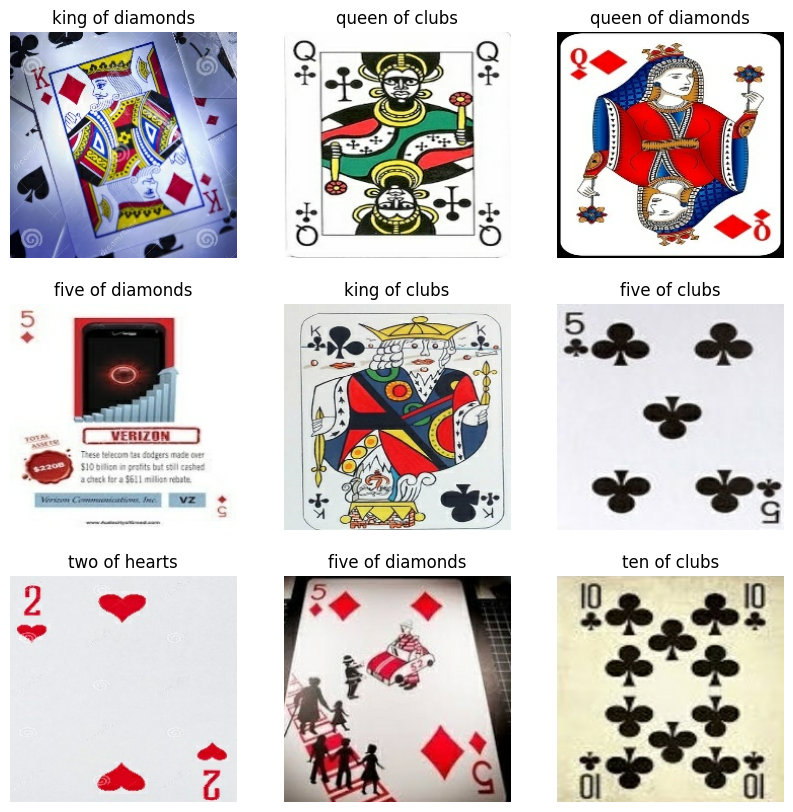

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = np.argmax(labels[i].numpy())
        class_name = class_names[label_index]
        plt.title(class_name)
        plt.axis("off")

---

## 5. Making a dataframe to track the performance of different models : {-}

In [11]:
column_names1 = ['Model_Name','Accuracy','Precision','Training_time(s)']
datatypes = {'Model_Name': str, 'Accuracy': float, 'Precision': float,'Training_time(s)':float}
df = pd.DataFrame(columns=column_names1).astype(datatypes)

## 6. Building CNN models {-}

### Defining functions for Early Stopping, Learning Rate Scheduling and Saving best model checkpoint: {-}

In [12]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=10)

Modifying for our baseline model : {-}

In [14]:
early_stopping_callback1 = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=15)

In [15]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_baseline_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')


In [16]:
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2,
                                                 patience=5,
                                                 verbose=1,
                                                 min_lr=1e-7)

### Defining a layer for data augmentation : {-}

In [17]:
AUGMENTATION_FACTOR = 0.1

In [18]:
augmentation_layer = Sequential([
    RandomFlip("horizontal", seed=123),
    RandomRotation(AUGMENTATION_FACTOR, seed=123),
    RandomZoom(AUGMENTATION_FACTOR, seed=123),
    RandomHeight(AUGMENTATION_FACTOR, seed=123),
    RandomWidth(AUGMENTATION_FACTOR, seed=123),
    Rescaling(1/255.),
], name="augmentation_layer")

## 6.1 Building baseline CNN model : {-}

- This model has: 

1) Four convolutional layers 
2) Max Pooling layers
3) Batch Normalization layers
4) One Dense Layer 

! Without any data augmentation.

In [19]:
model1 = Sequential([
  layers.Input(shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 5, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  
  layers.Conv2D(64, 5, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  
  layers.Conv2D(128, 5, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  
  layers.Conv2D(256, 5, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(53, activation='softmax')
])

#### 6.1.1 Compiling baseline model and checking its structure: {-}

In [20]:
model1.compile(optimizer='Adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy','precision'])

In [21]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 53)             │        13,621 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,938,933 (53.17 MB)

 Trainable params: 13,937,973 (53.17 MB)

 Non-trainable params: 960 (3.75 KB)

#### 6.1.2 Fitting the model for 100 epochs with Early Stopping, LR scheduling and model checkpoint callbacks : {-}

In [22]:
start1=time.time()
history1 = model1.fit(
  train_dataset,
  validation_data=valid_dataset,
  epochs=100,verbose=1,
callbacks=[early_stopping_callback1,model_checkpoint,reduce_lr_callback])

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


  2/239 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.0156 - loss: 17.4239 - precision: 0.0303          

I0000 00:00:1719741571.827157     120 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


239/239 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - accuracy: 0.0435 - loss: 10.1870 - precision: 0.0656 - val_accuracy: 0.0868 - val_loss: 4.8806 - val_precision: 0.1200 - learning_rate: 0.0010
Epoch 2/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.0748 - loss: 3.5851 - precision: 0.4034 - val_accuracy: 0.1094 - val_loss: 3.1953 - val_precision: 0.3333 - learning_rate: 0.0010
Epoch 3/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.0939 - loss: 3.3334 - precision: 0.4136 - val_accuracy: 0.1208 - val_loss: 2.8182 - val_precision: 0.5000 - learning_rate: 0.0010
Epoch 4/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.1055 - loss: 3.1871 - precision: 0.3918 - val_accuracy: 0.1396 - val_loss: 3.0495 - val_precision: 0.4000 - learning_rate: 0.0010
Epoch 5/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.1132 - loss: 3.1201 - precision: 0.4120 - val_accuracy: 0.1887 - val_loss: 2.5843 - val_precision: 0.4286 - learning_rate: 0.0010
Epoch 6/100
239

In [24]:
end1=time.time()

#### 6.1.3 Visualising baseline model's training and validation performance : {-}

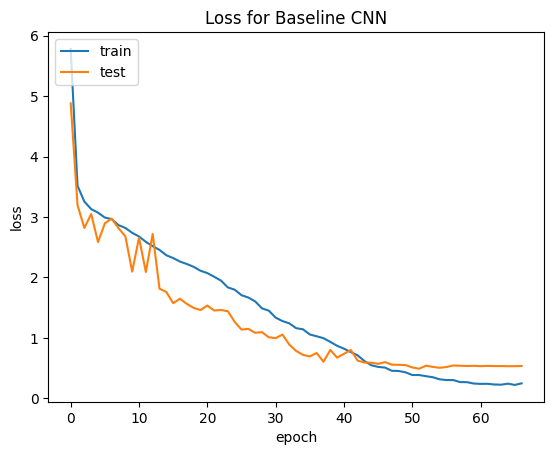

In [25]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Loss for Baseline CNN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

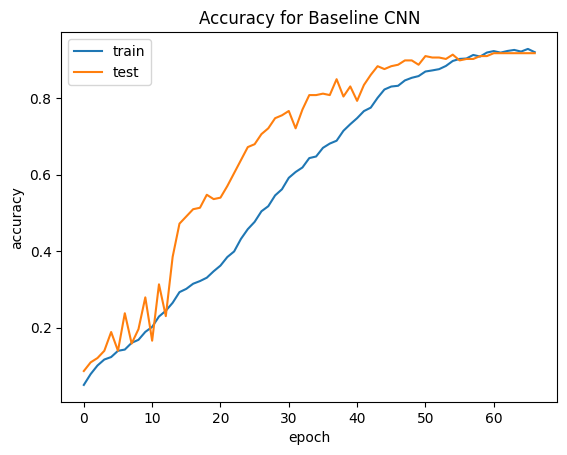

In [26]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Accuracy for Baseline CNN')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

#### 6.1.4 Evaluating model on testing data and saving its metrics : {-}

In [27]:
m1_eval=model1.evaluate(test_dataset)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9117 - loss: 0.4769 - precision: 0.9382


In [28]:
print(m1_eval)

[0.6416582465171814, 0.8792452812194824, 0.9169960618019104]


In [29]:
df.loc[len(df)] = ['Baseline_Model',m1_eval[1],m1_eval[2],(end1-start1)]

---

## 6.2 Building Model 2 : With EfficientNetB1 {-}

This model has:

1) Augmentation layer 
2) Base layers of EfficientNetB1
3) One dense layer


#### Downloading the pretrained base : {-}

In [31]:
efnetb1 = tf.keras.applications.EfficientNetB1(weights='imagenet',include_top=False,input_shape=(img_height, img_width, 3))
efnetb1.training = False

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#### 6.2.1 Building the model : {-}

In [32]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(img_height,img_width) + (3, ), name="input_layer"),
    augmentation_layer,
    efnetb1,
    tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer"),
    tf.keras.layers.Dense(256, activation=tf.keras.activations.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(len(class_names), activation=tf.keras.activations.softmax)
])

####  6.2.2 Compiling the model and checking its structure : {-}

In [33]:
model2.compile(optimizer='Adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy','precision'])

In [34]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation_layer (Sequential) │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb1 (Functional)     │ (None, None, None,     │     6,575,239 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 53)             │        13,621 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,917,820 (26.39 MB)

 Trainable params: 6,855,253 (26.15 MB)

 Non-trainable params: 62,567 (244.41 KB)

#### 6.2.3 Fitting the model for 100 epochs : {-}

In [35]:
model2_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_efnetb0_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

In [36]:
start2=time.time()
history2 = model2.fit(
  train_dataset,
  validation_data=valid_dataset,
  epochs=100,verbose=1,callbacks=[early_stopping_callback,model2_checkpoint,reduce_lr_callback])

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-06-30 10:13:48.177804: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/efficientnetb1_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


239/239 ━━━━━━━━━━━━━━━━━━━━ 154s 405ms/step - accuracy: 0.2776 - loss: 2.8406 - precision: 0.4986 - val_accuracy: 0.0189 - val_loss: 4.5471 - val_precision: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 88s 366ms/step - accuracy: 0.6808 - loss: 1.1365 - precision: 0.8443 - val_accuracy: 0.5962 - val_loss: 1.4252 - val_precision: 0.8170 - learning_rate: 0.0010
Epoch 3/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 87s 363ms/step - accuracy: 0.7623 - loss: 0.8715 - precision: 0.8837 - val_accuracy: 0.8679 - val_loss: 0.4572 - val_precision: 0.9237 - learning_rate: 0.0010
Epoch 4/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 87s 365ms/step - accuracy: 0.7953 - loss: 0.7337 - precision: 0.8995 - val_accuracy: 0.9208 - val_loss: 0.3229 - val_precision: 0.9365 - learning_rate: 0.0010
Epoch 5/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 85s 354ms/step - accuracy: 0.8207 - loss: 0.6135 - precision: 0.9146 - val_accuracy: 0.8755 - val_loss: 0.3852 - val_precision: 0.9076 - learning_rate: 0.0010
Epoch 6

In [37]:
end2=time.time()

#### 6.2.4 Visualising model performance : {-}

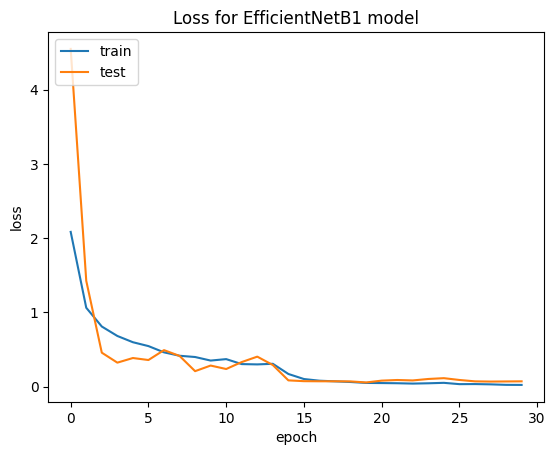

In [38]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Loss for EfficientNetB1 model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

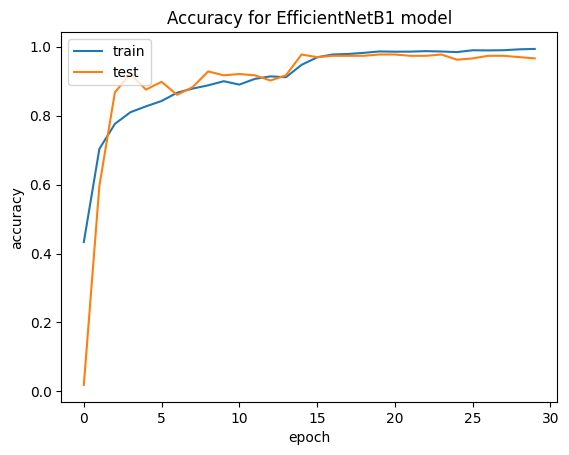

In [39]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Accuracy for EfficientNetB1 model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

#### The EfficientNetB1 transfer learning model visibly converged to higher validation accuracy values faster than the baseline model, crossing 90% within the 10 epochs, even though individual epochs took longer to train. {-}

----

#### 6.2.5 Evaluating model on the testing data and saving its performance metrics: {-}

In [40]:
m2_eval=model2.evaluate(test_dataset)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9606 - loss: 0.1418 - precision: 0.9720


In [41]:
df.loc[len(df)] = ['EfficientNetB1',m2_eval[1],m2_eval[2],(end2-start2)]

----

## 7. Comparing performance of both models : {-}

In [42]:
print(df)

       Model_Name  Accuracy  Precision  Training_time(s)
0  Baseline_Model  0.879245   0.916996        747.207493
1  EfficientNetB1  0.943396   0.957854       2800.077686
